# NDVI using STAC
### Using NDVI, what is the average total area of “barren” (barren rock, sand, or snow) land for the Santa Cruz province of Argentina for the month of November, 2020.

https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [44]:
import json
import dask.distributed
import folium
import folium.plugins
import rasterio
import geopandas as gpd
import shapely.geometry
from shapely.geometry import mapping
from IPython.display import HTML, display
from pystac_client import Client
import dask
import rioxarray as rxr
import numpy as np
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

from odc.stac import configure_rio, load
import stackstac

In [2]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [3]:
country = "Argentina"
province = "Santa Cruz"

<Axes: >

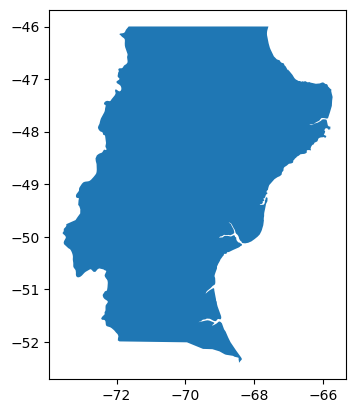

In [4]:
provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")
# Find Santa Cruz in the dataset
scdf = provinces.loc[(provinces['name'] == province) & (provinces['admin'] == country)]
scdf = scdf.reset_index(drop=True)
scdf.plot()

In [5]:
# Get the geojson polygon of the province
santa_cruz_dict = scdf.iloc[0].geometry.__geo_interface__

santa_cruz_polygon = json.dumps(santa_cruz_dict)

----

In [6]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52896,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52908,Total threads: 3
Dashboard: http://127.0.0.1:52911/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52899,


----

Using Earth Search API with STAC: https://stacindex.org/catalogs/earth-search#/

Which collection should we use? Let's go with Sentinel 2, but there are two levels: 2A and 1C.

Level-1C product provides orthorectified Top-Of-Atmosphere (TOA) reflectance, with sub-pixel multispectral registration. Cloud and land/water masks are included in the product.

Level-2A product provides orthorectified atmospherically corrected Surface Reflactance, with sub-pixel multispectral registration. A Scene Classification map (cloud, cloud shadows, vegetation, soils/deserts, water, snow, etc.) is included in the product.

----

# Using StackStac

https://stackstac.readthedocs.io/en/latest/basic.html

In [18]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")
catalog.title

'Earth Search by Element 84'

In [19]:
items = catalog.search(collections=["sentinel-2-l2a"], datetime="2020-11-01/2020-11-04", intersects=santa_cruz_polygon).item_collection()
len(items)

85

In [20]:
stack = stackstac.stack(items,resolution=1000, epsg=3857)

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [21]:
stack

<xarray.DataArray 'stackstac-ecbad7dce53c12c6a3ef72e2ecbfadb9' (time: 85,
                                                                band: 32,
                                                                y: 1412, x: 1138)>
dask.array<fetch_raster_window, shape=(85, 32, 1412, 1138), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2020-11-01...
    id                                       (time) <U24 'S2B_19GCK_20201101_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 -8.349e+06 ... -7.21...
  * y                                        (y) float64 -5.634e+06 ... -7.04...
    s2:processing_baseline                   (time) <U5 '02.14' ... '02.14'
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-8349000, -7046000, -7211000, ...
    crs:         epsg:3857
    transform:   | 1000.00, 0.00,-8349000.00|\n| 0.00,-1000.00,-5634000.00|\n...
    resolution:  1000

In [22]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]

In [13]:
rgb = lowcloud.sel(band=["red", "green", "blue", "nir"])

In [14]:
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [15]:
monthly

<xarray.DataArray 'stackstac-93bac522b459579fcc2f0637a81b638d' (time: 2,
                                                                band: 4,
                                                                y: 1412, x: 1138)>
dask.array<stack, shape=(2, 4, 1412, 1138), dtype=float64, chunksize=(1, 1, 326, 261), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                                     (band) <U12 'red' 'green' ... 'nir'
  * x                                        (x) float64 -8.349e+06 ... -7.21...
  * y                                        (y) float64 -5.634e+06 ... -7.04...
    constellation                            <U10 'sentinel-2'
    instruments                              <U3 'msi'
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    gsd                                      (band) object 10 10 10 10
    common_name                              (band) object 'red' ... 'nir'
    center_wavelength                        (band) object 0.665 0.56 0.49 0.842
    full_width_half_max                      (band) object 0.038 0.045 ... 0.145
    epsg                                     int64 3857
  * time                                     (time) datetime64[ns] 2020-11-01...
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-8349000, -7046000, -7211000, ...
    crs:         epsg:3857
    transform:   | 1000.00, 0.00,-8349000.00|\n| 0.00,-1000.00,-5634000.00|\n...
    resolution:  1000

In [16]:
client.wait_for_workers(4)

In [ ]:
rgb_n = monthly.compute()

NDVI = (NIR - RED) / (NIR + RED), where
- RED is B4, 664.5 nm
- NIR is B8, 835.1 nm

Refrences:\
https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#\
https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac\
https://stacindex.org/catalogs/earth-search#/43bjKKcJQfxYaT1ir3Ep6uENfjEoQrjkzhd2?t=3\
https://www.coiled.io/\

----

# Using odc.stac
https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [7]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")
catalog.title

'Earth Search by Element 84'

In [8]:
query = catalog.search(collections=["sentinel-2-l2a"], datetime="2020-11-01/2020-12-01", intersects=santa_cruz_polygon)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 787 datasets


In [9]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

In [10]:
gdf.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

In [11]:
# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

In [12]:
cloud_free = gdf[gdf['eo:cloud_cover'] < 20]

In [13]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="700px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

# folium.GeoJson(
#     style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
#     name="Query",
# ).add_to(map1)

cloud_free.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(cloud_free.unary_union.bounds))
display(fig)

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


----

In [48]:
cfg = {
    "sentinel-s2-l2a": {
        # "assets": {
        #     "*": {"data_type": "uint16", "nodata": 0},
        #     "SCL": {"data_type": "uint8", "nodata": 0},
        #     "visual": {"data_type": "uint8", "nodata": 0},
        # },
        "aliases": {"red": "B04", "green": "B03", "blue": "B02", "nir":"B08"},
    },
    "*": {"warnings": "ignore"},
}

In [49]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"

ds = load(
    items,
    bands=("red", "nir"),
    crs=crs,
    resolution=1000,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
    #geopolygon=json.loads(santa_cruz_polygon)
)
display(ds)

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138, time: 25)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2020-11-01T14:45:34.941000 ... 2020-12...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1412, 1138), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1412, 1138), meta=np.ndarray>

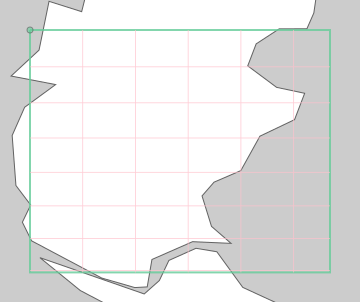

In [50]:
ds.odc.geobox

In [51]:
ds["NDVI"] = (ds.nir - ds.red) / (ds.nir + ds.red)

In [52]:
ds = ds.compute()

In [53]:
ds

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138, time: 25)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2020-11-01T14:45:34.941000 ... 2020-12...
Data variables:
    red          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    NDVI         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

(array([1.0063235e+07, 4.4057000e+04, 1.0322000e+04, 4.6560000e+03,
        5.0740000e+03, 1.4390000e+03, 1.6020000e+03, 1.9230000e+03,
        0.0000000e+00, 4.3970000e+03]),
 array([    0. ,  2184.5,  4369. ,  6553.5,  8738. , 10922.5, 13107. ,
        15291.5, 17476. , 19660.5, 21845. ]),
 <BarContainer object of 10 artists>)

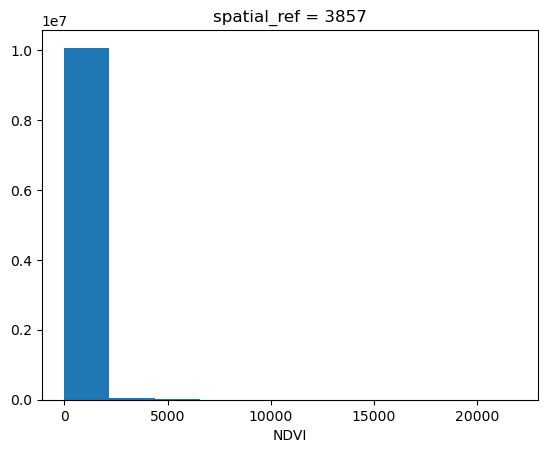

In [54]:
ds.NDVI.plot()

In [55]:
print("Max:",ds.NDVI.max())
print("Min:",ds.NDVI.min())
print("Mean:",ds.NDVI.mean())
print("Median:",ds.NDVI.median())

Max: <xarray.DataArray 'NDVI' ()>
array(21845.)
Coordinates:
    spatial_ref  int32 3857
Min: <xarray.DataArray 'NDVI' ()>
array(0.)
Coordinates:
    spatial_ref  int32 3857
Mean: <xarray.DataArray 'NDVI' ()>
array(74.55504022)
Coordinates:
    spatial_ref  int32 3857
Median: <xarray.DataArray 'NDVI' ()>
array(0.14399093)
Coordinates:
    spatial_ref  int32 3857


### Clearly there are some outliers, as there should be no values > 1. Judging by the histogram, there are not many outliers, so we will just drop the ones above 1

In [56]:
ds = ds.where(ds['NDVI'] < 1.0)

(array([3931482., 2411379.,  911272.,  331326.,  206821.,  139172.,
          87917.,   62149.,   40647.,    5264.]),
 array([0.        , 0.09995378, 0.19990756, 0.29986134, 0.39981511,
        0.49976889, 0.59972267, 0.69967645, 0.79963023, 0.89958401,
        0.99953779]),
 <BarContainer object of 10 artists>)

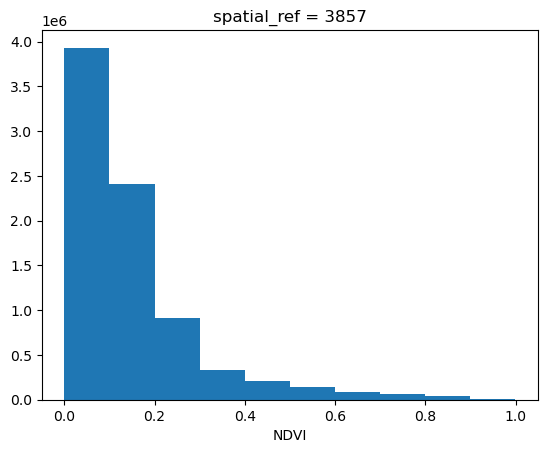

In [57]:
ds.NDVI.plot()

In [58]:
# Collapse the time dimension by taking the median value for each pixel over the month
ds = ds.median(dim='time')
ds

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
Data variables:
    red          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nir          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    NDVI         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

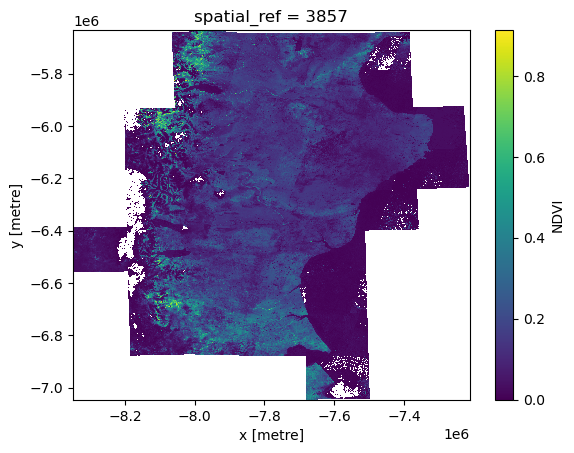

In [59]:
ndvi = ds.NDVI
ndvi.plot()

In [60]:
ndvi_clip = ndvi.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)

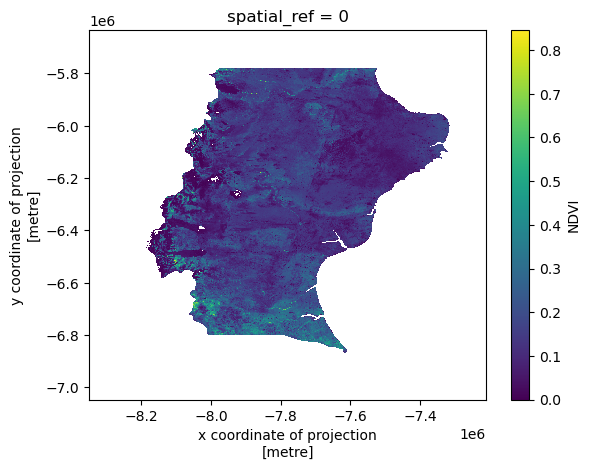

In [61]:
ndvi_clip.plot()

In [62]:
ndvi_clip

<xarray.DataArray 'NDVI' (y: 1412, x: 1138)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int64 0

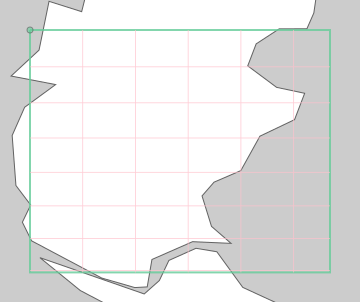

In [63]:
ndvi_clip.odc.geobox

In [64]:
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_density_class = np.digitize(ndvi_clip, ndvi_class_bins)

In [65]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes = np.unique(ndvi_density_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

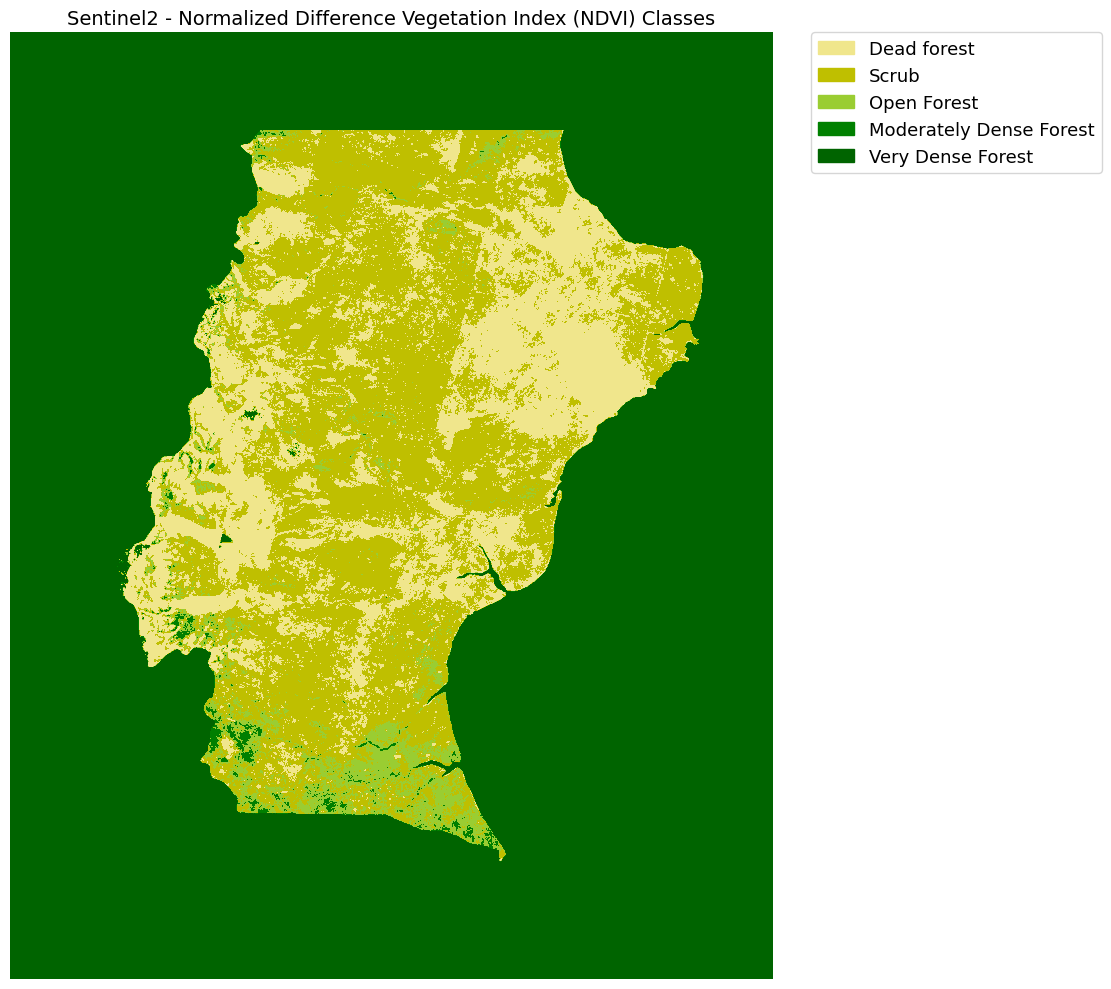

In [66]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()
im1 = ax.imshow(np.squeeze(ndvi_density_class), cmap=nbr_cmap)
ep.draw_legend(im_ax=im1, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()
plt.tight_layout()